In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn

from einops import rearrange

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
eth_file = '../knn/Ethereum_01.12.2018-28.02.2025_historical_data_coinmarketcap.csv'

df_btc = pd.read_csv(btc_file, sep=';')
df_eth = pd.read_csv(eth_file, sep=';')

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [3]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
                          name      open      high       low     close  \
timestamp                                                                
2025-03-19T23:59:59.999Z  2781  0.577186  0.616542  0.595481  0.651858   
2025-03-18T23:59:59.999Z  2781  0.601675  0.565420  0.570740  0.577225   
2025-03-17T23:59:59.999Z  2781  0.574615  0.576695  0.594100  0.601717   
2025-03-16T23:59:59.999Z  2781  0.606324  0.582358  0.585657  0.574720   
2025-03-15T23:59:59.999Z  2781  0.599738  0.575781  0.614528  0.606543   

                            volume  marketCap  
timestamp                                      
2025-03-19T23:59:59.999Z  0.179920   0.657170  
2025-03-18T23:59:59.999Z  0.102163   0.582669  
2025-03-17T23:59:59.999Z  0.109318   0.606958  
2025-03-16T23:59:59.999Z  0.082319   0.580049  
2025-03-15T23:59:59.999Z  0.027212   0.611688  
Shape: (399, 7)


In [4]:
def prepare_data(df, window_size=5):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [5]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2=None, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_size1))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        if hidden_size2:
            layers.append(nn.Linear(hidden_size1, hidden_size2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_size2, 1))
        else:
            layers.append(nn.Linear(hidden_size1, 1))
            
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        # Self-attention: query=key=value=x
        out, _ = self.attn(x, x, x)
        return out

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads, dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

class InformerModel(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)  # бо кожен таймстеп має 1 значення
        self.encoder = nn.Sequential(
            *[EncoderLayer(d_model, n_heads, dropout) for _ in range(num_layers)]
        )
        self.projection = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: (batch_size, window_size)
        x = x.unsqueeze(-1)  # -> (batch_size, window_size, 1)
        x = self.embedding(x)  # -> (batch_size, window_size, d_model)
        x = self.encoder(x)    # -> (batch_size, window_size, d_model)
        x = x[:, -1, :]        # беремо останній таймстеп
        return self.projection(x)  # -> (batch_size, 1)


In [7]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001):
    print(f"Training {model_name}...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()
    
    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    
    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)
    
    return model

In [8]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [10]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]
    
    for hidden_config in hidden_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                experiment_count += 1

                # if len(hidden_config) == 1:
                #     model = MLPModel(input_size=input_size, 
                #                    hidden_size1=hidden_config[0])
                #     model_name = f"MLP_w{window_size}_h{hidden_config[0]}_lr{lr}_e{epochs}"
                # else:
                #     model = MLPModel(input_size=input_size, 
                #                    hidden_size1=hidden_config[0],
                #                    hidden_size2=hidden_config[1])
                #     model_name = f"MLP_w{window_size}_h{hidden_config[0]}-{hidden_config[1]}_lr{lr}_e{epochs}"
                model = InformerModel(input_size=input_size)
                model_name = f"Informer_w{window_size}_d64_h4_l2_lr{lr}_e{epochs}"
                print(f"\n[{experiment_count}/{total_experiments}] {model_name}")


                
                run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                              target_scaler, results, epochs=epochs, lr=lr)

print("\n" + "=" * 80)
print(" ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



 Window size: 5
Training set shape: (315, 30)
Test set shape: (79, 30)

[2/90] Informer_w5_d64_h4_l2_lr0.001_e50
Training Informer_w5_d64_h4_l2_lr0.001_e50...
Epoch 20/50, Loss: 0.028010
Epoch 40/50, Loss: 0.009820
RMSE: 6247.3630, MAE: 5174.3973
--------------------------------------------------

[3/90] Informer_w5_d64_h4_l2_lr0.001_e100
Training Informer_w5_d64_h4_l2_lr0.001_e100...
Epoch 20/100, Loss: 0.102335
Epoch 40/100, Loss: 0.089750
Epoch 60/100, Loss: 0.088839
Epoch 80/100, Loss: 0.087704
Epoch 100/100, Loss: 0.088260
RMSE: 13979.4378, MAE: 12586.0681
--------------------------------------------------

[4/90] Informer_w5_d64_h4_l2_lr0.001_e1000
Training Informer_w5_d64_h4_l2_lr0.001_e1000...
Epoch 20/1000, Loss: 0.091273
Epoch 40/1000, Loss: 0.090774
Epoch 60/1000, Loss: 0.088479
Epoch 80/1000, Loss: 0.088167
Epoch 100/1000, Loss: 0.088008
Epoch 120/1000, Loss: 0.087918
Epoch 140/1000, Loss: 0.088950
Epoch 160/1000, Loss: 0.087421
Epoch 180/1000, Loss: 0.088883
Epoch 200/100

KeyboardInterrupt: 

In [11]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
Informer_w5_d64_h4_l2_lr0.001_e100       2221.4015  1806.4129  0.001835    
Informer_w5_d64_h4_l2_lr0.01_e50         12648.5664 11088.1062 0.088934    
Informer_w5_d64_h4_l2_lr0.01_e100        13046.5045 11540.2247 0.087976    
Informer_w5_d64_h4_l2_lr0.01_e1000       13810.6524 12397.3754 0.088086    
Informer_w5_d64_h4_l2_lr0.001_e50        14058.9060 12675.8661 0.087879    
Informer_w5_d64_h4_l2_lr0.001_e1000      14262.4440 12899.3773 0.088296    

 НАЙКРАЩА МОДЕЛЬ: Informer_w5_d64_h4_l2_lr0.001_e100
   RMSE: 2221.4015
   MAE: 1806.4129

 АНАЛІЗ ПО WINDOW SIZE:
Window 5: Найкращий RMSE = 2221.4015, Середній RMSE = 11674.7458


In [ ]:
# def run_complete_analysis(df, feature_scaler, target_scaler, best_model, 
#                          X_test, y_test, model_name):
#     """
#     Запуск повного аналізу моделі
#     """
#     print("🚀 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ")
#     print("=" * 60)
    
#     # Ініціалізація аналізатора
#     analyzer = ModelAnalyzer(df, feature_scaler, target_scaler)
    
#     # 1. Аналіз кореляцій
#     correlation_matrix = analyzer.analyze_correlations()
    
#     # 2. Розподіл ознак
#     analyzer.create_feature_distributions()
    
#     # 3. Детальний аналіз найкращої моделі
#     # results = analyzer.analyze_best_model(best_model, X_test, y_test, model_name)
    
#     # 4. Аналіз важливості ознак
#     feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
#     analyzer.create_feature_importance_analysis(best_model, X_test, feature_names)
    
#     print(f"\n✅ АНАЛІЗ ЗАВЕРШЕНО!")
#     print("=" * 60)
    
#     return analyzer, results

# # Приклад використання (додайте це до основного коду):

# # Після навчання всіх моделей та визначення найкращої:
# best_model_name = sorted_results[0][0]  # Назва найкращої моделі
# # Тут потрібно зберегти саму модель під час навчання та передати її сюда

# # Запуск аналізу
# analyzer, analysis_results = run_complete_analysis(
#     df=scaled_df,
#     feature_scaler=feature_scaler, 
#     target_scaler=target_scaler,
#     best_model=best_model[0],  
#     X_test=X_test,
#     y_test=y_test,
#     model_name=best_model_name
# )


--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


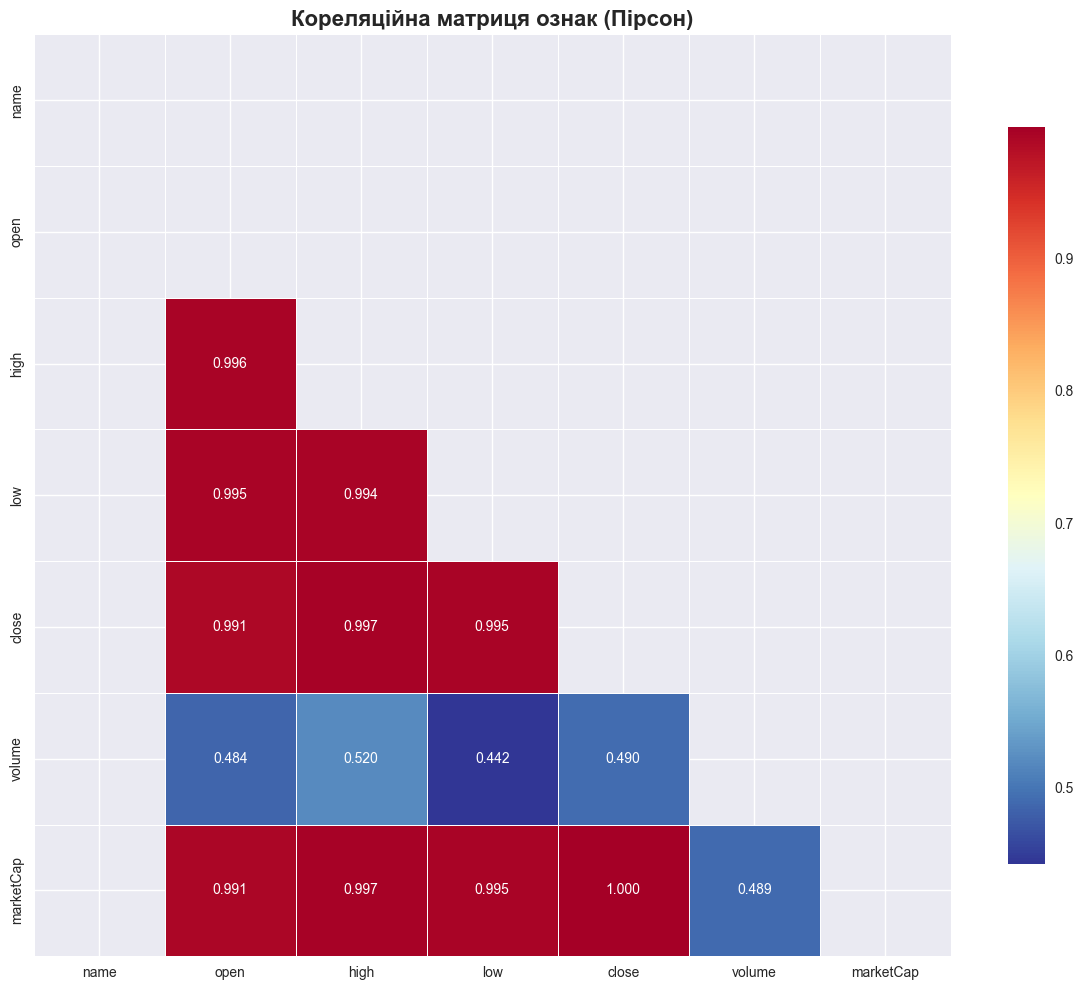


 Найсильніші кореляції:
 1. close        ↔ marketCap   :  1.000
 2. high         ↔ marketCap   :  0.997
 3. high         ↔ close       :  0.997
 4. open         ↔ high        :  0.996
 5. low          ↔ marketCap   :  0.995
 6. low          ↔ close       :  0.995
 7. open         ↔ low         :  0.995
 8. high         ↔ low         :  0.994
 9. open         ↔ marketCap   :  0.991
10. open         ↔ close       :  0.991

 РОЗПОДІЛ ОЗНАК


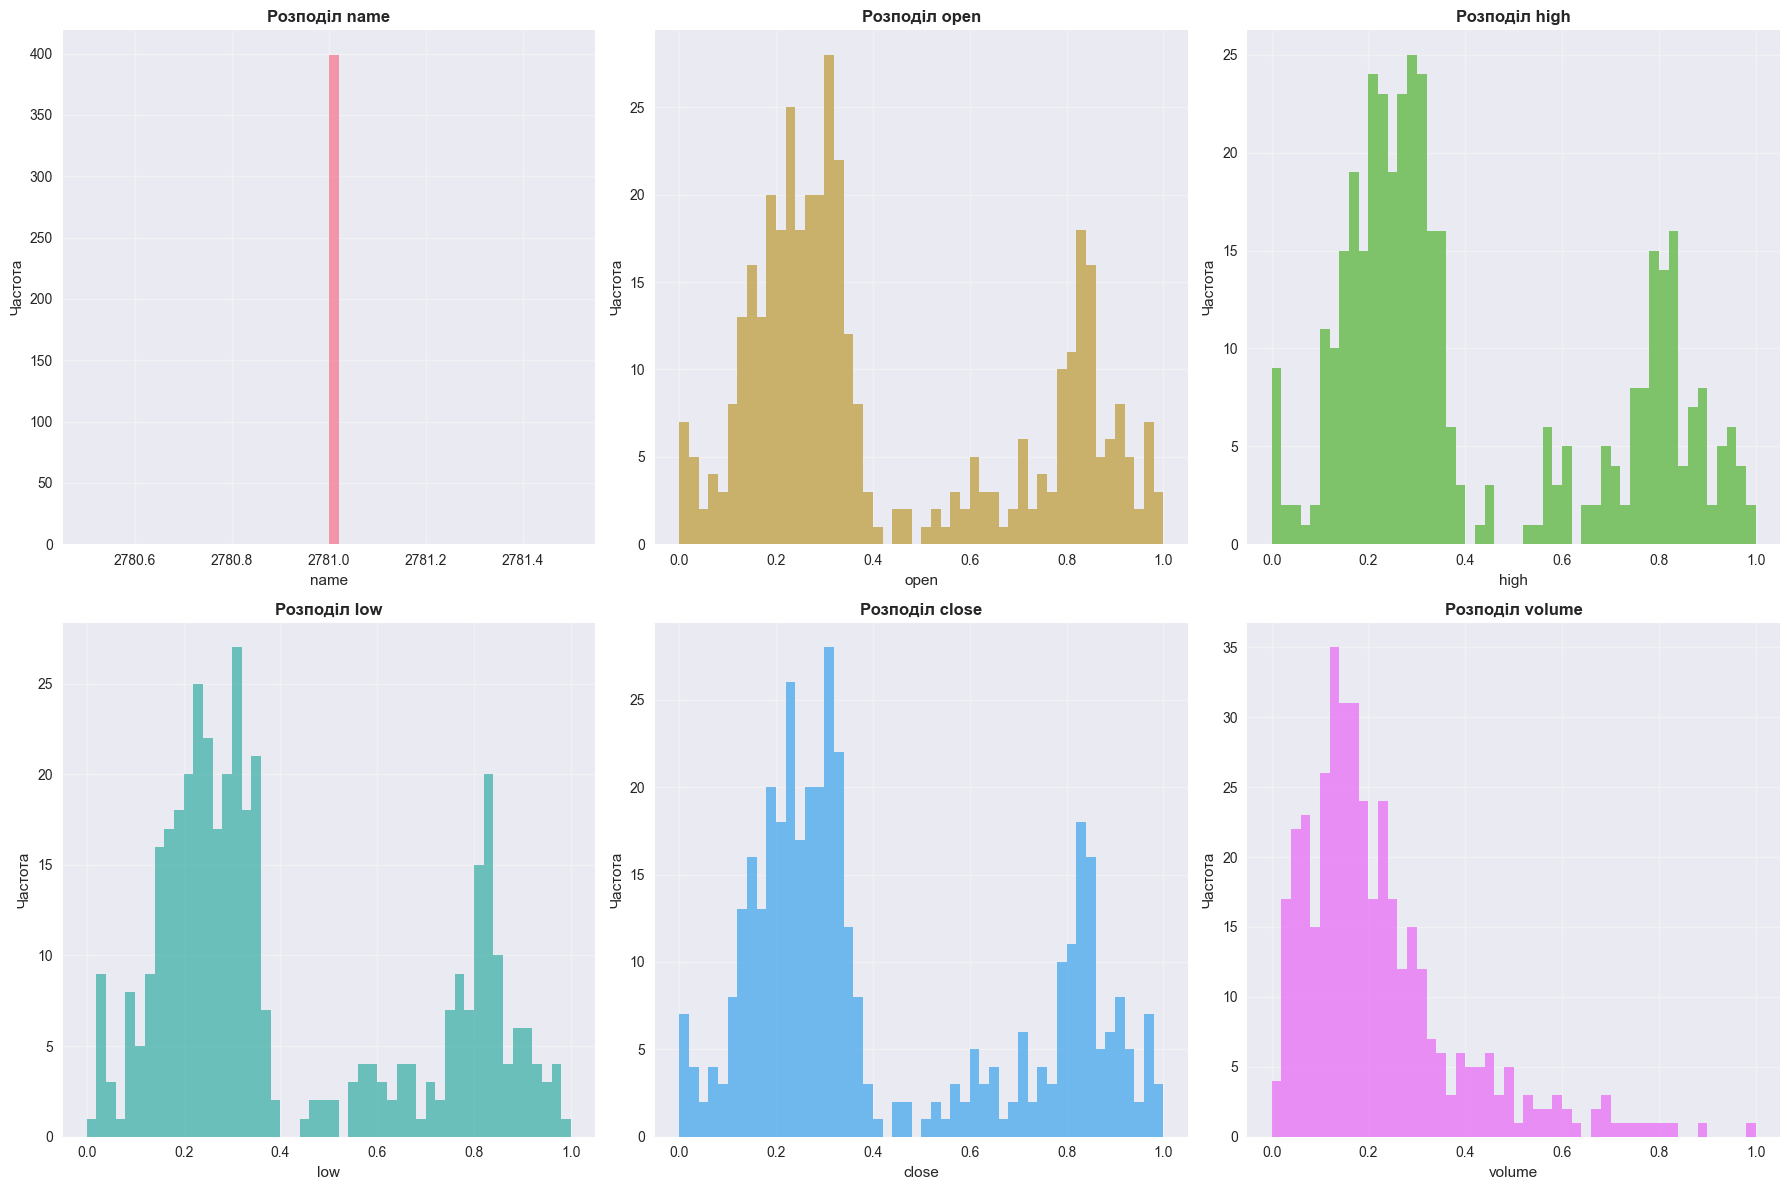


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: Informer_w5_d64_h4_l2_lr0.001_e100
 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 2221.4015
MAE (Mean Absolute Error): 1806.4129
MAPE (Mean Absolute Percentage Error): 2.86%
R² Score: 0.8668
Explained Variance Score: 0.8689


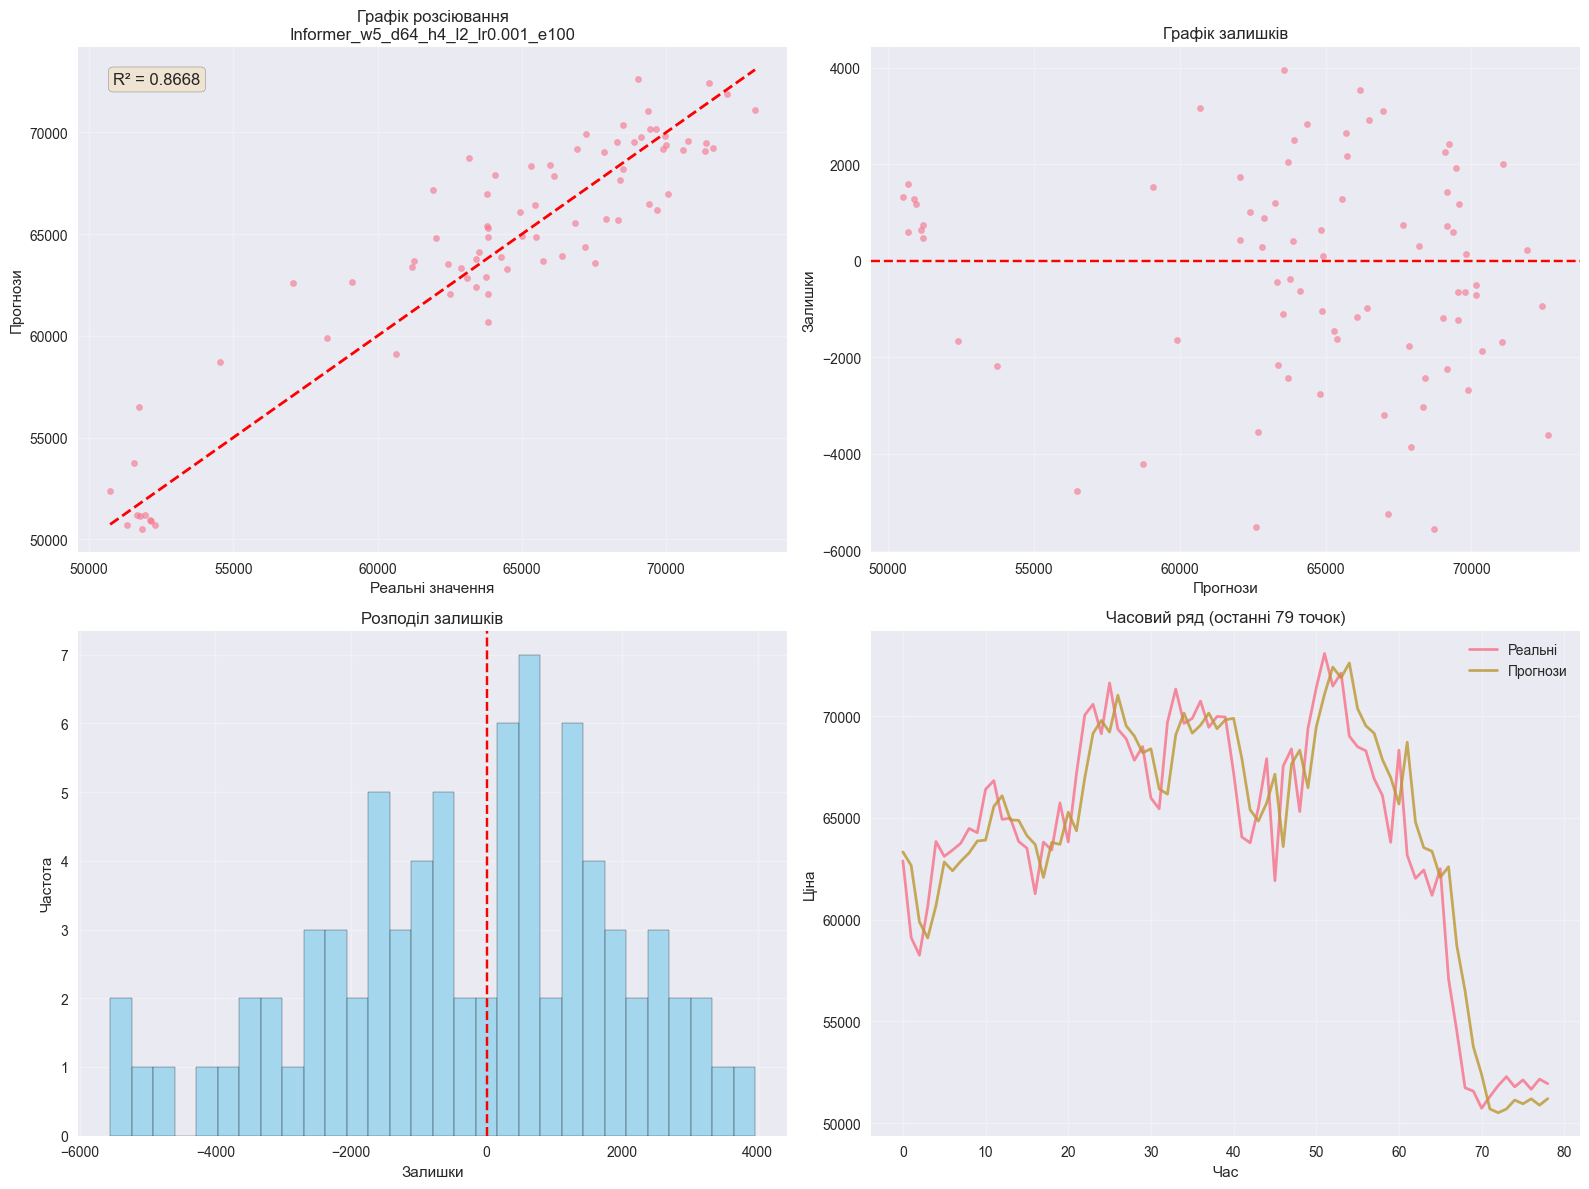


 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.4487
Precision: 0.4476
Recall: 0.4487
F1-Score: 0.4481

 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.49      0.50      0.49        42
   Зростання       0.40      0.39      0.39        36

    accuracy                           0.45        78
   macro avg       0.44      0.44      0.44        78
weighted avg       0.45      0.45      0.45        78



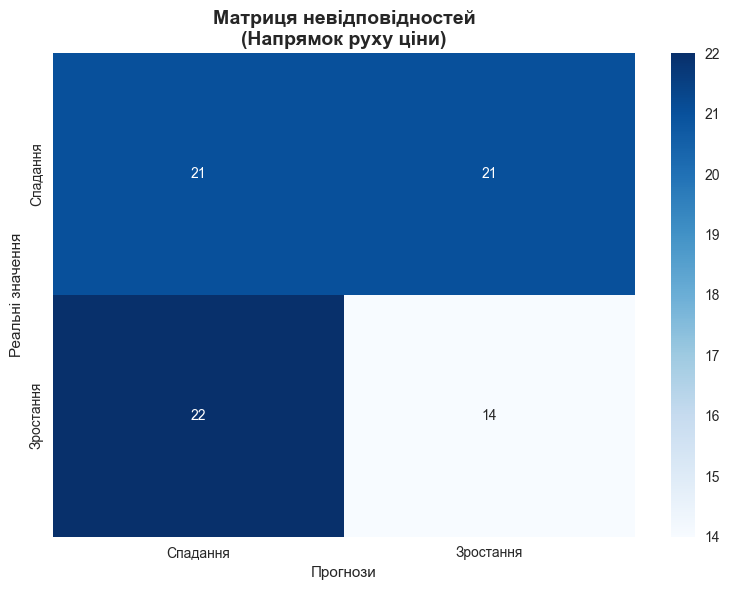


 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 21
False Positives (помилково передбачені зростання): 21
False Negatives (пропущені зростання): 22
True Positives (правильно передбачені зростання): 14

 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.4487     Частка правильних прогнозів             
Precision    0.4476     Частка правильних позитивних прогнозів  
Recall       0.4487     Частка знайдених позитивних випадків    
F1-Score     0.4481     Гармонічне середнє Precision і Recall   


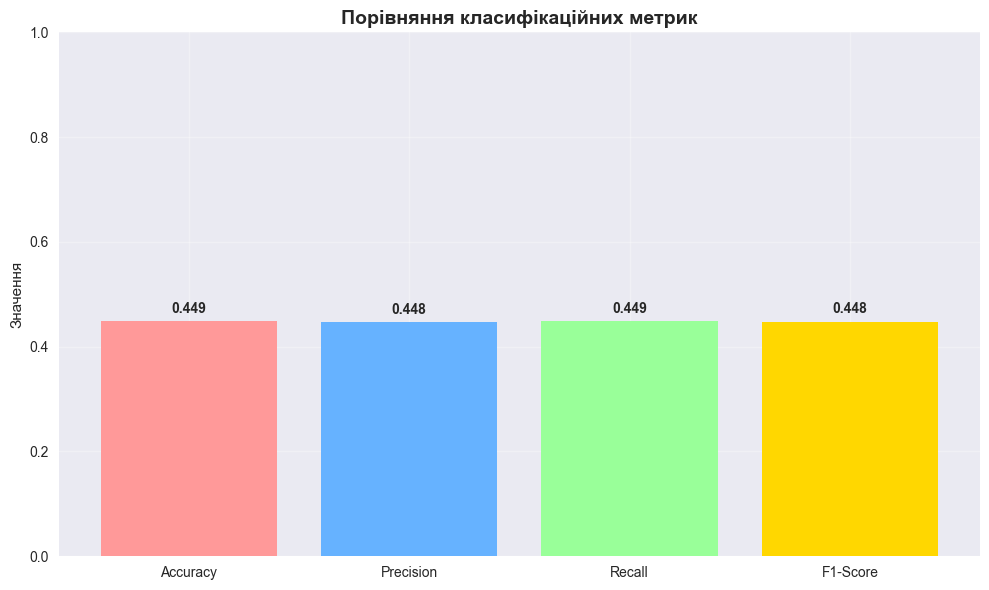


 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
 Статистика параметрів моделі:
Загальна кількість параметрів: 50,625
Навчальні параметри: 50,625

 Статистика вхідних ознак:
       Feature       Mean     Std        Min        Max
0    Feature_0  2781.0000  0.0000  2781.0000  2781.0000
1    Feature_1     0.2506  0.0978     0.0000     0.4032
2    Feature_2     0.2549  0.0942     0.0000     0.3862
3    Feature_3     0.2451  0.0911     0.0256     0.3955
4    Feature_4     0.2080  0.1246     0.0381     0.6669
5    Feature_5     0.2505  0.0932     0.0000     0.3977
6    Feature_6  2781.0000  0.0000  2781.0000  2781.0000
7    Feature_7     0.2483  0.1009     0.0000     0.4032
8    Feature_8     0.2526  0.0977     0.0000     0.3862
9    Feature_9     0.2430  0.0937     0.0256     0.3955
10  Feature_10     0.2075  0.1249     0.0381     0.6669
11  Feature_11     0.2484  0.0965     0.0000     0.3977
12  Feature_12  2781.0000  0.0000  2781.0000  2781.0000
13  Feature_13     0.2457  0.1042     0.0000     0.4032
14  Featu

In [12]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)